In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.distributions import MultivariateNormal
import copy
from copy import deepcopy
from tqdm import tqdm
import os
import pickle
import gc

# Ensure the device is GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Model with update1 function for task 1.1 and update2 for task 1.2

In [ ]:
class GPUProbabilisticLwP:
    def __init__(self, covariance_type='full', n_pseudo_samples=1000, swd_projections=1000):
        self.covariance_type = covariance_type
        self.n_pseudo_samples = n_pseudo_samples
        self.swd_projections = swd_projections
        self.prototypes = None
        self.covariances = None
        self.priors = None
        self.classes = None
        self.samples_in_each_class = None
        self.scaler = StandardScaler()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    def _compute_covariance(self, X):
        """
        Compute the covariance matrix based on the specified type.
        """
        X = X.cpu().numpy()
        # print(f"X shape: {X.shape}")
        if X.shape[0] > X.shape[1]:
            cov = np.cov(X.T) + 1e-4 * np.eye(X.shape[1])
        else:
            # Use bias=True to handle degrees of freedom <= 0
            cov = np.cov(X.T, bias=True) + 1e-4 * np.eye(X.shape[1])
        cov = torch.tensor(cov, device=self.device)
        return cov

    def _generate_pseudo_dataset(self):
        print(f"Generating pseudo dataset with {self.n_pseudo_samples} samples...")
        n_features = self.prototypes[0].shape[0]
        pseudo_samples = torch.zeros((self.n_pseudo_samples, n_features), device=self.device)
        pseudo_labels = torch.zeros(self.n_pseudo_samples, device=self.device)

        start_idx = 0
        for idx, (prototype, covariance, prior) in enumerate(zip(self.prototypes,
                                                               self.covariances,
                                                               self.priors)):
            n_samples = int(self.n_pseudo_samples * prior.item())
            if idx == len(self.classes) - 1:
                n_samples = self.n_pseudo_samples - start_idx

            if n_samples > 0:

                prototype = prototype.float()  # or prototype.double() for consistency with Double tensors
                covariance = covariance.float()  # or covariance.double()
                dist = MultivariateNormal(prototype, covariance)
                samples = dist.sample((n_samples,))

                pseudo_samples[start_idx:start_idx + n_samples] = samples
                pseudo_labels[start_idx:start_idx + n_samples] = self.classes[idx]
                start_idx += n_samples

        return pseudo_samples, pseudo_labels

    def _compute_swd(self, P, Q, n_projections=100):
        min_samples = min(P.shape[0], Q.shape[0])
        if P.shape[0] > min_samples:
            idx = torch.randperm(P.shape[0], device=self.device)[:min_samples]
            P = P[idx]
        if Q.shape[0] > min_samples:
            idx = torch.randperm(Q.shape[0], device=self.device)[:min_samples]
            Q = Q[idx]

        dim = P.shape[1]
        projections = torch.randn(n_projections, dim, device=self.device)
        projections /= torch.norm(projections, dim=1, keepdim=True)

        P_projs = torch.mm(P, projections.T)
        Q_projs = torch.mm(Q, projections.T)

        P_projs, _ = torch.sort(P_projs, dim=0)
        Q_projs, _ = torch.sort(Q_projs, dim=0)

        swd = torch.mean(torch.sum((P_projs - Q_projs) ** 2, dim=0))
        return torch.sqrt(swd)

    def fit(self, X_train, y_train):
        if X_train is None or y_train is None:
            raise ValueError("Training data and labels cannot be None")

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32, device=self.device)
        y_train = torch.tensor(y_train, device=self.device)

        self.classes = torch.unique(y_train)
        n_samples = len(y_train)

        self.prototypes = []
        self.covariances = []
        self.priors = []
        self.samples_in_each_class = []

        for label in self.classes:
            mask = (y_train == label)
            class_samples = X_train_scaled[mask]
            self.samples_in_each_class.append(len(class_samples))
            if len(class_samples) > 0:
                prototype = torch.mean(class_samples, dim=0)
                self.prototypes.append(prototype)

                covariance = self._compute_covariance(class_samples)
                self.covariances.append(covariance)

                self.priors.append(torch.tensor(len(class_samples) / n_samples,
                                              device=self.device))

        self.prototypes = torch.stack(self.prototypes)
        self.covariances = torch.stack(self.covariances)
        self.priors = torch.stack(self.priors)

    def update1(self, X_target, confidence=0.9):
        if X_target is None:
            raise ValueError("Target data cannot be None")

        X_target_scaled = self.scaler.transform(X_target)
        X_target_scaled = torch.tensor(X_target_scaled, dtype=torch.float32, device=self.device)

        # predict the pseudo labels
        pseudo_labels = self.predict(X_target)
        pseudo_labels = torch.tensor(pseudo_labels, device=self.device)

        # filter out the samples with low confidence
        probas = self.predict_proba(X_target)
        max_probas, _ = torch.max(probas, dim=1)
        mask = (max_probas > confidence)
        X_target_filtered = X_target_scaled[mask]
        pseudo_labels_filtered = pseudo_labels[mask]

        print(f"size of filtered target samples: {len(X_target_filtered)}")

        old_sample_size = sum(self.samples_in_each_class)
        print(f"Old sample size: {old_sample_size}")

        # update the model
        for label in self.classes:
            # complete the update function here
            mask = (pseudo_labels_filtered == label)
            class_samples = X_target_filtered[mask]

            if len(class_samples) > 0:

                prototype = torch.mean(class_samples, dim=0)
                covariance = self._compute_covariance(class_samples)
                prior = torch.tensor(len(class_samples) / len(X_target_filtered), device=self.device)

                # Update the prototypes, covariances, and priors
                self.prototypes[label] = (self.samples_in_each_class[label] * self.prototypes[label] + len(class_samples) * prototype) / (self.samples_in_each_class[label] + len(class_samples))
                self.covariances[label] = (self.samples_in_each_class[label] * self.covariances[label] + len(class_samples) * covariance) / (self.samples_in_each_class[label] + len(class_samples))
                self.priors[label] = (self.samples_in_each_class[label] * self.priors[label] + len(class_samples) * prior) / (self.samples_in_each_class[label] + len(class_samples))

                self.samples_in_each_class[label] += len(class_samples)

        print(f"Updating model with {len(X_target)} target samples...")

    def update2(self, X_target, max_iterations=10, threshold=0.01):
        X_target_scaled = self.scaler.transform(X_target)
        X_target_scaled = torch.tensor(X_target_scaled, dtype=torch.float32, device=self.device)

        best_swd = float('inf')
        best_state = None

        for iteration in range(max_iterations):
            # Generate pseudo-dataset
            pseudo_samples, pseudo_labels = self._generate_pseudo_dataset()

            # Compute distribution alignment
            current_swd = self._compute_swd(X_target_scaled, pseudo_samples, self.swd_projections)
            print(f"Iteration {iteration + 1}: SWD = {current_swd}")

            # Track best state
            if current_swd < best_swd:
                best_swd = current_swd
                best_state = {
                    'prototypes': self.prototypes.clone(),
                    'covariances': self.covariances.clone(),
                    'priors': self.priors.clone()
                }

            # Early stopping condition
            if iteration > 0 and abs(current_swd - prev_swd) < threshold:
                break
            prev_swd = current_swd

            # Confident sample selection with more robust approach
            probas = self.predict_proba(X_target)
            confidence_mask = self._get_robust_confidence_mask(probas)

            if not torch.any(confidence_mask):
                break

            # Update distribution with more careful parameter mixing
            self._update_distribution(X_target_scaled, probas, confidence_mask)

        # Restore best state if final state is worse
        if best_state and best_swd < current_swd:
            self.prototypes = best_state['prototypes']
            self.covariances = best_state['covariances']
            self.priors = best_state['priors']

        return best_swd

    def _get_robust_confidence_mask(self, probas, confidence_threshold=0.9, entropy_threshold=0.5):
        # More robust confidence selection
        max_probs = torch.max(probas, dim=1)[0]
        entropies = -torch.sum(probas * torch.log(probas + 1e-10), dim=1)

        confidence_mask = (
            (max_probs > confidence_threshold)
            # & (entropies < entropy_threshold)
        )
        return confidence_mask

    def _update_distribution(self, X_target_scaled, probas, confidence_mask):
        # More careful distribution update
        confident_samples = X_target_scaled[confidence_mask]
        confident_labels = self.classes[torch.argmax(probas[confidence_mask], dim=1)]
        print(f"Confident samples: {len(confident_samples)}")

        updated_prototypes = []
        updated_covariances = []
        updated_priors = []

        for label in self.classes:
            mask = (confident_labels == label)
            label_samples = confident_samples[mask]

            if len(label_samples) > 0:
                # Adaptive learning rate based on sample confidence
                alpha = min(0.5, len(label_samples) / len(X_target_scaled))

                idx = torch.where(self.classes == label)[0][0]

                # Weighted update of prototype
                new_prototype = torch.mean(label_samples, dim=0)
                updated_prototype = alpha * new_prototype + (1 - alpha) * self.prototypes[idx]
                updated_prototypes.append(updated_prototype)

                # Update covariance with more stability
                new_covariance = self._compute_covariance(label_samples)
                updated_covariance = alpha * new_covariance + (1 - alpha) * self.covariances[idx]
                updated_covariances.append(updated_covariance)

                # Prior update
                new_prior = torch.tensor(len(label_samples) / len(X_target_scaled), device=self.device)
                updated_prior = alpha * new_prior + (1 - alpha) * self.priors[idx]
                updated_priors.append(updated_prior)
            else:
                # Maintain existing parameters for classes without confident samples
                idx = torch.where(self.classes == label)[0][0]
                updated_prototypes.append(self.prototypes[idx])
                updated_covariances.append(self.covariances[idx])
                updated_priors.append(self.priors[idx])

        # Update model parameters
        self.prototypes = torch.stack(updated_prototypes)
        self.covariances = torch.stack(updated_covariances)
        self.priors = torch.stack(updated_priors)
        self.priors /= torch.sum(self.priors)

    def predict_proba(self, X_test):
        X_test_scaled = self.scaler.transform(X_test)
        X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32, device=self.device)
        n_samples = len(X_test_scaled)
        n_classes = len(self.classes)
        probas = torch.zeros((n_samples, n_classes), device=self.device)

        for i, (prototype, covariance, prior) in enumerate(zip(self.prototypes,
                                                             self.covariances,
                                                             self.priors)):
            dist = MultivariateNormal(prototype, covariance)
            log_probs = dist.log_prob(X_test_scaled) + torch.log(prior)

            probas[:, i] = log_probs
        probas = probas / 1000000  # Normalize to avoid numerical instability
        probas = torch.exp(probas - torch.max(probas, dim=1, keepdim=True)[0])
        probas /= torch.sum(probas, dim=1, keepdim=True)
        # print(f"Probas testing for initial model: {probas[0]}")
        return probas

    def predict(self, X_test):
        probas = self.predict_proba(X_test)
        probas_np = probas.cpu().numpy()  # Convert to NumPy here
        return self.classes.cpu().numpy()[np.argmax(probas_np, axis=1)]


## Train function for D1 to D10 which uses update1 function

In [3]:
def train_and_evaluate_gpu(features_dir, classifier_class=GPUProbabilisticLwP):
    accuracies = np.zeros((10, 10))

    print("Phase 2: Training and evaluating models...")
    print("Training initial model...")
    print(f"Classifier: {classifier_class.__name__}")

    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load and train initial model
    with open(f"{features_dir}/1_train_features.pkl", 'rb') as f:
        D1_data = pickle.load(f)

    print(f"Fitting initial model... {D1_data['features'].shape} {D1_data['labels'].shape}")

    model = classifier_class(covariance_type='full')
    model.fit(D1_data['features'], D1_data['labels'])

    # Evaluate on D1
    with open(f"{features_dir}/1_test_features.pkl", 'rb') as f:
        test_data = pickle.load(f)
    predictions = model.predict(test_data['features'])
    accuracy = np.mean(predictions == test_data['labels'])
    accuracies[0, 0] = accuracy

    print(f"Initial model accuracy: {accuracy:.4f}")

    # Iteratively train remaining models
    for i in tqdm(range(2, 11), desc="Training models"):
        print(f"\nTraining model {i}...")

        # Clear CUDA cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

        # Load current dataset features
        with open(f"{features_dir}/{i}_train_features.pkl", 'rb') as f:
            Di_data = pickle.load(f)

        # Attempt domain adaptation
        model.update1(Di_data['features'])

        # Evaluate on all previous datasets
        for j in range(1, i + 1):
            with open(f"{features_dir}/{j}_test_features.pkl", 'rb') as f:
                test_data = pickle.load(f)
            predictions = model.predict(test_data['features'])
            accuracy = np.mean(predictions == test_data['labels'])
            accuracies[i-1, j-1] = accuracy

        print(f"Current accuracies for model {i}:")
        for j in range(1, i + 1):
            print(f"  Domain {j}: {accuracies[i-1, j-1]:.4f}")

    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    return model, accuracies


In [4]:
# Step 2: Train and evaluate LwP models
features_dir = "features"
# Print accuracy matrix

model10, accuracies = train_and_evaluate_gpu(features_dir)
# save the model
torch.save(model10, 'model10.pt')

print(accuracies)

Phase 2: Training and evaluating models...
Training initial model...
Classifier: GPUProbabilisticLwP
Using device: cuda
Fitting initial model... (2500, 2048) (2500,)
Initial model accuracy: 0.8760


Training models:   0%|          | 0/9 [00:00<?, ?it/s]


Training model 2...
size of filtered target samples: 11
Old sample size: 2500
Updating model with 2500 target samples...


Training models:  11%|█         | 1/9 [00:09<01:13,  9.20s/it]

Current accuracies for model 2:
  Domain 1: 0.8780
  Domain 2: 0.8904

Training model 3...
size of filtered target samples: 17
Old sample size: 2511
Updating model with 2500 target samples...


Training models:  22%|██▏       | 2/9 [00:20<01:13, 10.50s/it]

Current accuracies for model 3:
  Domain 1: 0.8772
  Domain 2: 0.8900
  Domain 3: 0.8724

Training model 4...
size of filtered target samples: 13
Old sample size: 2528
Updating model with 2500 target samples...


Training models:  33%|███▎      | 3/9 [00:34<01:11, 11.95s/it]

Current accuracies for model 4:
  Domain 1: 0.8780
  Domain 2: 0.8908
  Domain 3: 0.8724
  Domain 4: 0.8808

Training model 5...
size of filtered target samples: 4
Old sample size: 2541
Updating model with 2500 target samples...


Training models:  44%|████▍     | 4/9 [00:50<01:07, 13.44s/it]

Current accuracies for model 5:
  Domain 1: 0.8780
  Domain 2: 0.8900
  Domain 3: 0.8728
  Domain 4: 0.8808
  Domain 5: 0.8760

Training model 6...
size of filtered target samples: 7
Old sample size: 2545
Updating model with 2500 target samples...


Training models:  56%|█████▌    | 5/9 [01:08<01:00, 15.09s/it]

Current accuracies for model 6:
  Domain 1: 0.8784
  Domain 2: 0.8900
  Domain 3: 0.8732
  Domain 4: 0.8808
  Domain 5: 0.8768
  Domain 6: 0.8816

Training model 7...
size of filtered target samples: 12
Old sample size: 2552
Updating model with 2500 target samples...


Training models:  67%|██████▋   | 6/9 [01:28<00:50, 16.84s/it]

Current accuracies for model 7:
  Domain 1: 0.8788
  Domain 2: 0.8892
  Domain 3: 0.8724
  Domain 4: 0.8796
  Domain 5: 0.8752
  Domain 6: 0.8820
  Domain 7: 0.8720

Training model 8...
size of filtered target samples: 11
Old sample size: 2564
Updating model with 2500 target samples...


Training models:  78%|███████▊  | 7/9 [01:50<00:37, 18.69s/it]

Current accuracies for model 8:
  Domain 1: 0.8784
  Domain 2: 0.8900
  Domain 3: 0.8736
  Domain 4: 0.8784
  Domain 5: 0.8756
  Domain 6: 0.8832
  Domain 7: 0.8696
  Domain 8: 0.8836

Training model 9...
size of filtered target samples: 11
Old sample size: 2575
Updating model with 2500 target samples...


Training models:  89%|████████▉ | 8/9 [02:15<00:20, 20.64s/it]

Current accuracies for model 9:
  Domain 1: 0.8776
  Domain 2: 0.8900
  Domain 3: 0.8736
  Domain 4: 0.8772
  Domain 5: 0.8752
  Domain 6: 0.8824
  Domain 7: 0.8688
  Domain 8: 0.8840
  Domain 9: 0.8756

Training model 10...
size of filtered target samples: 10
Old sample size: 2586
Updating model with 2500 target samples...


Training models: 100%|██████████| 9/9 [02:42<00:00, 18.07s/it]

Current accuracies for model 10:
  Domain 1: 0.8768
  Domain 2: 0.8916
  Domain 3: 0.8744
  Domain 4: 0.8772
  Domain 5: 0.8764
  Domain 6: 0.8816
  Domain 7: 0.8684
  Domain 8: 0.8852
  Domain 9: 0.8740
  Domain 10: 0.8808


[[0.876  0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.878  0.8904 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.8772 0.89   0.8724 0.     0.     0.     0.     0.     0.     0.    ]
 [0.878  0.8908 0.8724 0.8808 0.     0.     0.     0.     0.     0.    ]
 [0.878  0.89   0.8728 0.8808 0.876  0.     0.     0.     0.     0.    ]
 [0.8784 0.89   0.8732 0.8808 0.8768 0.8816 0.     0.     0.     0.    ]
 [0.8788 0.8892 0.8724 0.8796 0.8752 0.882  0.872  0.     0.     0.    ]
 [0.8784 0.89   0.8736 0.8784 0.8756 0.8832 0.8696 0.8836 0.     0.    ]
 [0.8776 0.89   0.8736 0.8772 0.8752 0.8824 0.8688 0.884  0.8756 0.    ]
 [0.8768 0.8916 0.8744 0.8772 0.8764 0.8816 0.8684 0.8852 0.874  0.8808]]


/tmp/ipykernel_57971/243545721.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


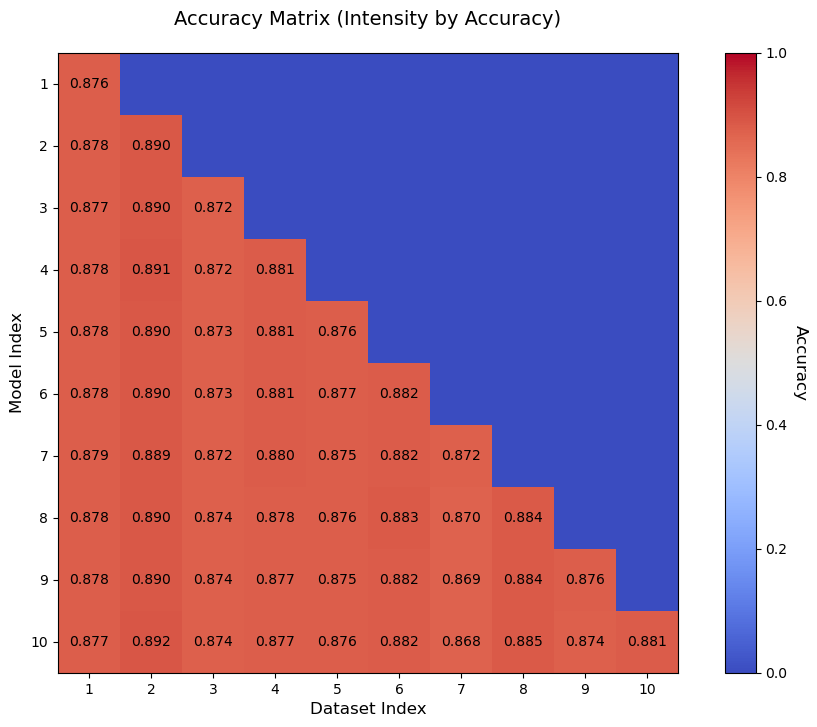

In [ ]:
# Plotting the accuracy matrix as a heatmap
accuracy_matrix = accuracies
num_models = accuracy_matrix.shape[0]

plt.figure(figsize=(12, 8))
heatmap = plt.matshow(
    accuracy_matrix,
    cmap='coolwarm',  # Changed colormap for better contrast
    fignum=1,
    vmin=0,
    vmax=1.0
)

# Add color bar with accuracy label
cbar = plt.colorbar(heatmap)
cbar.ax.set_ylabel('Accuracy', rotation=-90, va="bottom", fontsize=12)

# Add annotations to each cell with the accuracy values
for i in range(num_models):
    for j in range(i + 1):  # Only show lower triangle values
        value = accuracy_matrix[i, j]
        plt.text(
            j, i, f"{value:.3f}",
            ha='center',
            va='center',
            color="white" if value < 0.5 else "black",  # Change text color for contrast
            fontsize=10
        )

# Adjust tick labels to start from 1 instead of 0
plt.xticks(ticks=range(num_models), labels=range(1, num_models + 1), fontsize=10)
plt.yticks(ticks=range(num_models), labels=range(1, num_models + 1), fontsize=10)

# Set axis labels
plt.xlabel("Dataset Index", fontsize=12)
plt.ylabel("Model Index", fontsize=12)
plt.title("Accuracy Matrix (Intensity by Accuracy)", fontsize=14, pad=20)

# Remove gridlines for a clean look
plt.gca().xaxis.tick_bottom()  # Move x-axis ticks to the bottom
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()